<a href="https://www.kaggle.com/code/klimyuriy/dota-game-time-predict?scriptVersionId=197302814" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
import joblib

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/small-nice-data-dota2/small_nice_data.csv


In [2]:
df = pd.read_csv("/kaggle/input/small-nice-data-dota2/small_nice_data.csv",
                 index_col=0)

df

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,...,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
0,0,0,0,0,0,3,3,3,3,3,...,0,0,1,1,1,1,0,0,0,0
1,60,0,0,0,0,3,3,3,3,3,...,0,0,1,1,2,2,0,0,0,0
2,120,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
3,180,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
4,240,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164738,1200,0,0,1,1,0,3,3,3,3,...,0,0,0,1,10,16,0,1,0,1
164739,1260,0,0,1,0,0,2,3,3,3,...,0,0,3,1,13,17,0,1,0,0
164740,1320,0,0,1,0,0,2,3,3,3,...,0,1,0,0,13,17,0,1,0,0
164741,1380,0,0,1,0,0,1,3,3,3,...,3,1,0,1,13,18,0,1,0,0


In [3]:
df.describe()

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,...,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
count,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,...,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000
mean,1072.197079,0.285813,0.022069,0.197663,0.016932,1.661540,2.553670,2.872051,2.906032,2.916226,...,0.438497,0.423177,0.606409,0.596884,11.661236,11.479075,0.274583,0.187182,0.021272,0.016196
std,734.369752,0.607209,0.146910,0.491219,0.129019,1.229113,0.879006,0.467094,0.397592,0.376865,...,1.134580,1.116944,0.904239,0.900847,8.688824,8.478081,0.589938,0.476634,0.144290,0.126229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,480.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,1020.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,3.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000
75%,1560.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,0.000000,0.000000,1.000000,1.000000,17.000000,17.000000,0.000000,0.000000,0.000000,0.000000
max,5820.000000,6.000000,1.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,21.000000,19.000000,6.000000,7.000000,134.000000,106.000000,5.000000,5.000000,1.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164300 entries, 0 to 164742
Data columns (total 83 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time                       164300 non-null  int64  
 1   radiant_roshankill         164300 non-null  int64  
 2   radiant_Δroshankill        164300 non-null  int64  
 3   dire_roshankill            164300 non-null  int64  
 4   dire_Δroshankill           164300 non-null  int64  
 5   good_tower1                164300 non-null  int64  
 6   good_tower2                164300 non-null  int64  
 7   good_tower3                164300 non-null  int64  
 8   good_melee                 164300 non-null  int64  
 9   good_range                 164300 non-null  int64  
 10  good_fort                  164300 non-null  int64  
 11  bad_tower1                 164300 non-null  int64  
 12  bad_tower2                 164300 non-null  int64  
 13  bad_tower3                 164300 

In [5]:
X = df.drop(columns=['time'])
y = df['time']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((131440, 82), (32860, 82), (131440,), (32860,))

In [6]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_range', 'bad_fort', 'id', 'y...
       'radiant_secret_shop_cost', 'dire_secret_shop_cost',
       'radiant_null_cost', 'dire_null_cost', 'radiant_Δkills', 'dire_Δkills',
       'radiant_kills', 'dire_kills', 'radiant_Δbuyback', 'dire_Δbuyback',
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object'))])

In [7]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
model = lgb.LGBMRegressor(objective='mse',
                          n_estimators = 200)

In [9]:
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_names = ['test', 'train'],
          eval_metric='mae')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8357
[LightGBM] [Info] Number of data points in the train set: 131440, number of used features: 82
[LightGBM] [Info] Start training from score 1072.303256


LGBMRegressor(n_estimators=200, objective='mse')

In [10]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [11]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,23.52,25.03
RMSE,33.38,36.38
R2,1.00,1.00


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

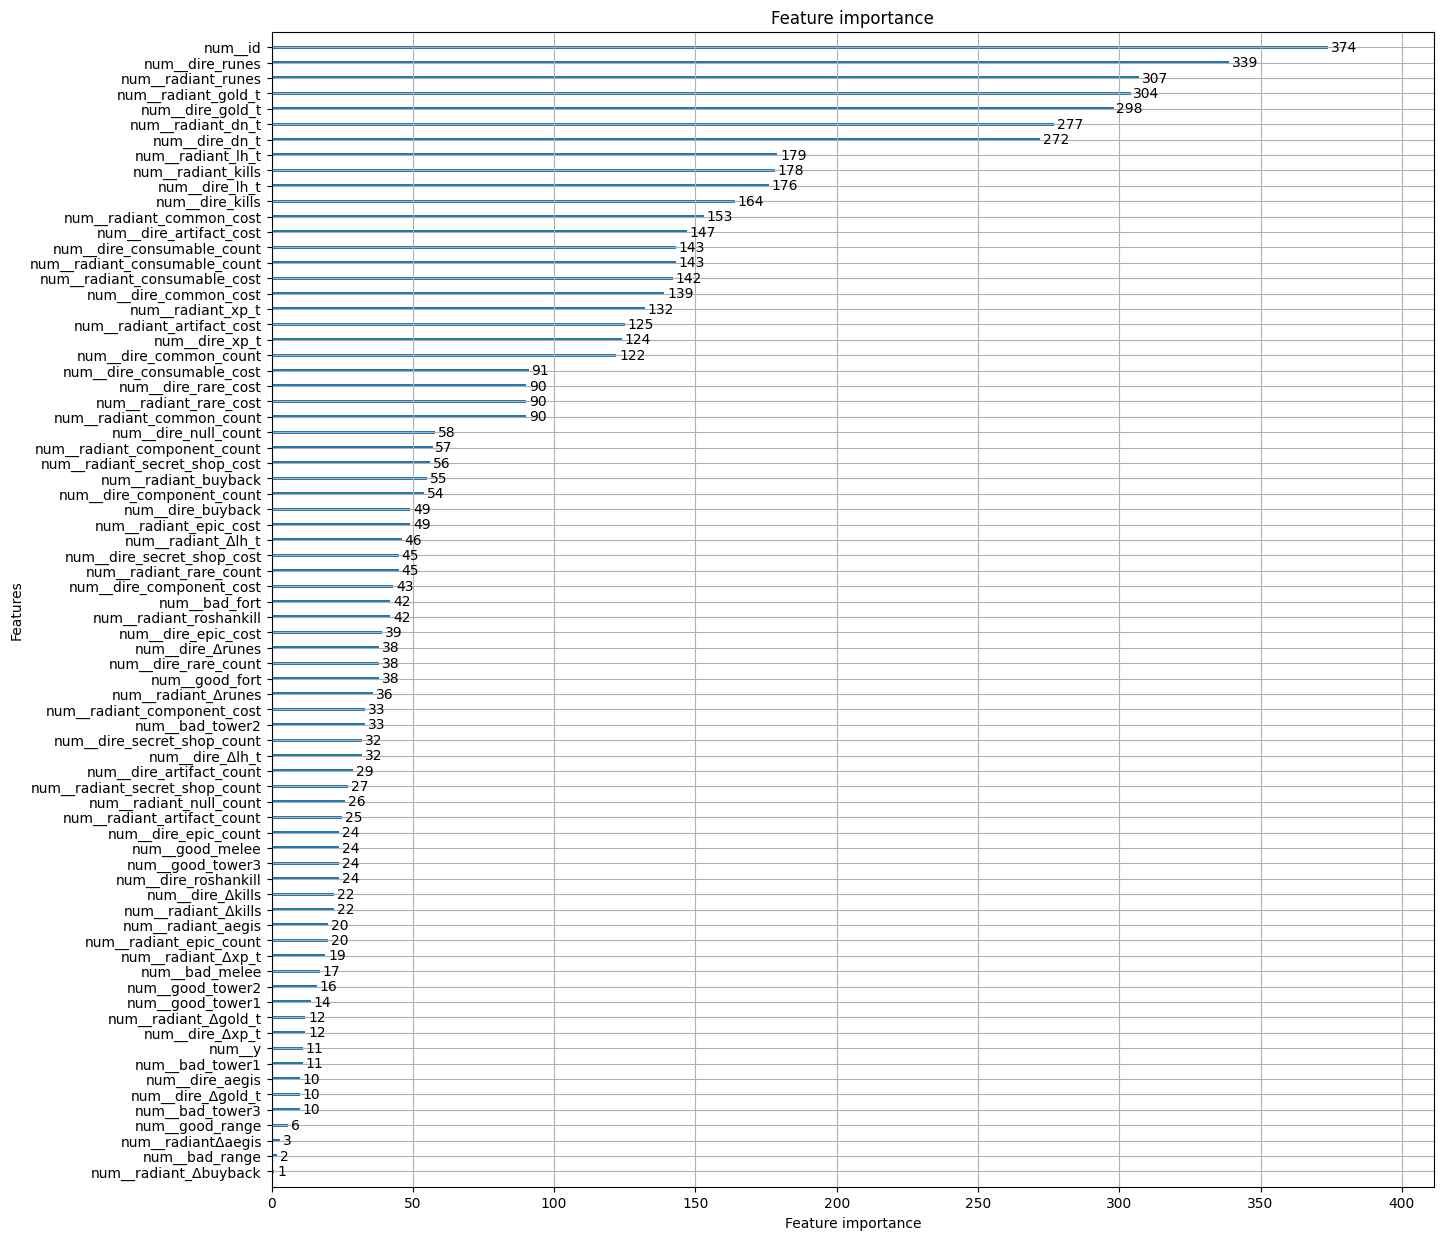

In [12]:
lgb.plot_importance(model, figsize=(15,15))

In [13]:
model.evals_result_['train'].keys()

odict_keys(['l1', 'l2'])

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

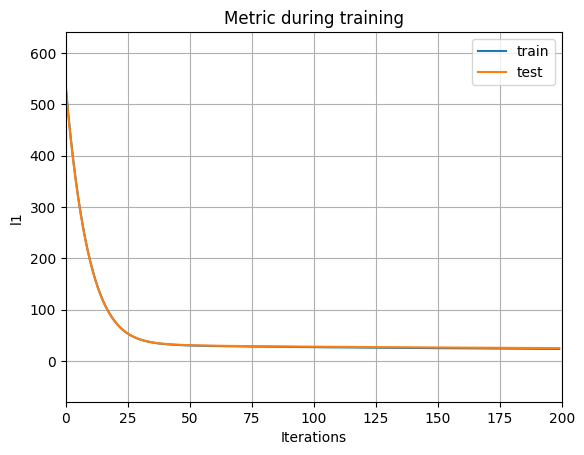

In [14]:
lgb.plot_metric(model,
                metric='l1')

In [15]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_r...
       'radiant_null_cost', 'dire_null_cost', 'radiant_Δkills', 'dire_Δkills',
       'radiant_kills', 'dire_kills', 'radiant_Δbuyback', 'dire_Δbuyback',
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object'))])),
                ('model', LGBMRegressor(n_estimators=200, objective='mse'))])

In [16]:
joblib.dump(model, 'my_model.pkl')

['my_model.pkl']

In [17]:
load_model = joblib.load('my_model.pkl')
load_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_r...
       'radiant_null_cost', 'dire_null_cost', 'radiant_Δkills', 'dire_Δkills',
       'radiant_kills', 'dire_kills', 'radiant_Δbuyback', 'dire_Δbuyback',
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object'))])),
                ('model', LGBMRegressor(n_estimators=200, objective='mse'))])